# 📧 Spam Email Classifier (logistic regression Model)
This notebook loads raw `.eml` files from folders, processes and trains a spam classifier using a logistic regression model.

In [10]:

import os
import re
import pandas as pd
import numpy as np
from collections import Counter
from email import policy
from email.parser import BytesParser
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib


In [11]:

def parse_email(file_path):
    with open(file_path, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)
    headers = dict(msg.items())
    body = msg.get_body(preferencelist=('plain', 'html'))
    return {
        "subject": headers.get("Subject", ""),
        "body": body.get_content() if body else ""
    }

def load_emails_from_folder(folder_path, label):
    emails = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        try:
            parsed = parse_email(file_path)
            emails.append({
                "subject": parsed["subject"],
                "text": parsed["body"],
                "label": label
            })
        except Exception:
            continue
    return emails

def clean_text(text):
    text = re.sub(r'\b\d+\b', ' ', text)
    text = re.sub(r'\b(?:\d{1,2}[: ]\d{2})\b', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


In [12]:
ham_emails = load_emails_from_folder("easy_ham", 0)
spam_emails = load_emails_from_folder("spam", 1)
spam2_emails = load_emails_from_folder("spam_2", 1)

all_emails = pd.DataFrame(ham_emails + spam_emails + spam2_emails)
all_emails['subject'] = all_emails['subject'].fillna('')
all_emails['text'] = all_emails['text'].fillna('')

# Boost subject influence by duplicating it
all_emails["combined_text"] = all_emails["subject"] * 2 + ' ' + all_emails["text"]
all_emails["cleaned_text"] = all_emails["combined_text"].apply(clean_text)

print(f"📬 Total emails loaded: {len(all_emails)}")
print(f"✅ Ham emails: {len(all_emails[all_emails['label'] == 0])}")
print(f"🚫 Spam emails: {len(all_emails[all_emails['label'] == 1])}")


📬 Total emails loaded: 4015
✅ Ham emails: 2501
🚫 Spam emails: 1514


In [13]:

X = all_emails['cleaned_text']
y = all_emails['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [14]:
from sklearn.linear_model import LogisticRegression

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.95,
        min_df=1,
        max_features=10000,
        ngram_range=(1, 2),  # Unigrams + bigrams
        stop_words='english',
        sublinear_tf=True,
        strip_accents='unicode',
        lowercase=True
    )),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

nb_pipeline.fit(X_train, y_train)

# save the model
joblib.dump(nb_pipeline, 'spam_classifier.pkl')
print("Model saved as spam_classifier.pkl")


Model saved as spam_classifier.pkl



Classification Report:

              precision    recall  f1-score   support

           0     0.9804    0.9980    0.9891       500
           1     0.9966    0.9670    0.9816       303

    accuracy                         0.9863       803
   macro avg     0.9885    0.9825    0.9853       803
weighted avg     0.9865    0.9863    0.9863       803



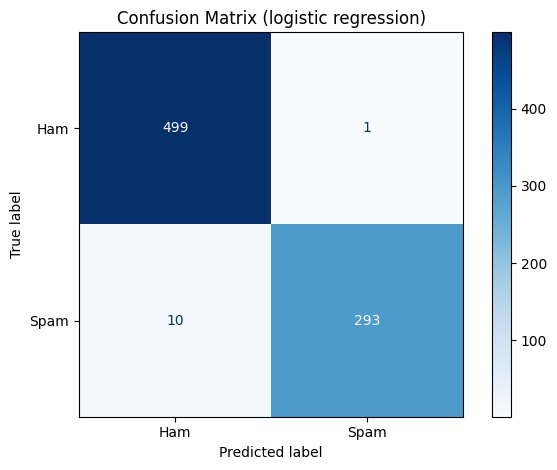

In [15]:

y_pred = nb_pipeline.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (logistic regression)")
plt.tight_layout()
plt.show()


In [16]:
# --- ANALYZE FALSE NEGATIVES (Missed Spam) ---
false_negatives_idx = np.where((y_test.values == 1) & (y_pred == 0))[0]
filename = "false_negatives.txt"

with open(filename, "w", encoding="utf-8") as f:
    f.write(f"Total false negatives (missed spam): {len(false_negatives_idx)}\n\n")
    for idx in false_negatives_idx:
        orig_idx = X_test.index[idx]
        f.write(f"--- Email index in test set: {idx} ---\n")
        f.write(f"Email Subject: {all_emails.iloc[orig_idx]['subject']}\n")
        f.write(f"Email Text: {all_emails.iloc[orig_idx]['combined_text']}\n")
        f.write(f"Actual Label: Spam\n")
        f.write(f"Predicted Label: Ham\n")
        f.write("-" * 50 + "\n")

print(f"✅ False negatives saved to: {filename}")



✅ False negatives saved to: false_negatives.txt


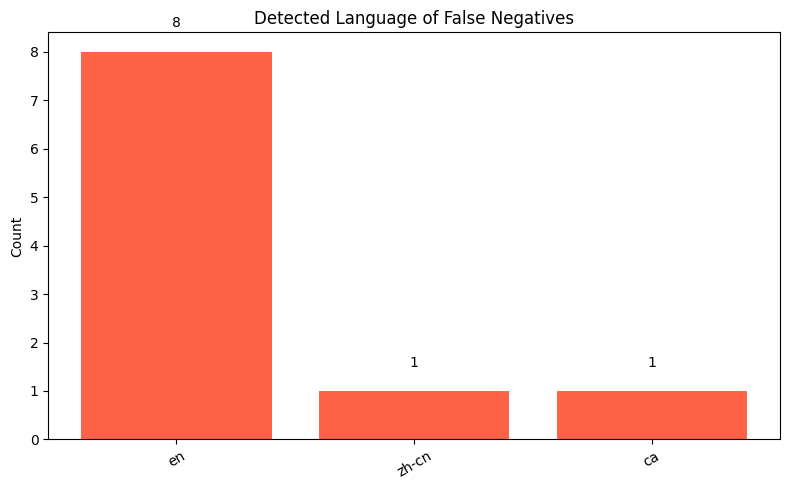

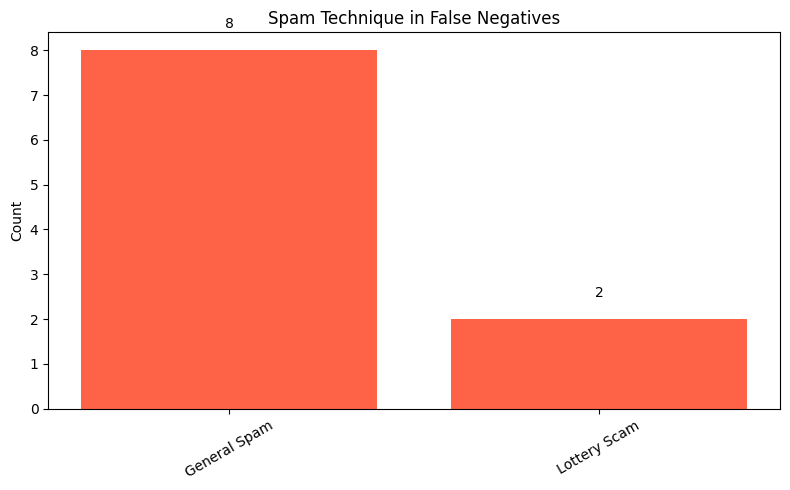

In [17]:
import re
import pandas as pd
from langdetect import detect
import matplotlib.pyplot as plt
from collections import Counter

# --- Load data from false_negatives.txt ---
def parse_false_negatives(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        content = f.read()

    entries = content.strip().split("-" * 50)
    records = []
    for entry in entries:
        if "Email Subject" not in entry:
            continue
        subject = re.search(r"Email Subject: (.*)", entry)
        text = re.search(r"Email Text: (.*)", entry, re.DOTALL)

        records.append({
            "subject": subject.group(1).strip() if subject else "",
            "text": text.group(1).strip() if text else ""
        })

    return pd.DataFrame(records)

df = parse_false_negatives("false_negatives.txt")
df["combined"] = df["subject"] + " " + df["text"]

# --- Language detection ---
def safe_detect(text):
    try:
        return detect(text)
    except:
        return "unknown"

df["language"] = df["combined"].apply(safe_detect)

# --- Keyword-based spam technique extraction ---
def detect_spam_technique(text):
    text = text.lower()
    if any(kw in text for kw in ["click here", "verify", "account", "login now", "reset password"]):
        return "Phishing"
    elif any(kw in text for kw in ["buy now", "discount", "limited offer", "promotion"]):
        return "Advertising"
    elif any(kw in text for kw in ["win", "prize", "congratulations", "gift card"]):
        return "Lottery Scam"
    elif any(kw in text for kw in ["security alert", "virus", "system warning", "infected"]):
        return "Fake Antivirus"
    else:
        return "General Spam"

df["technique"] = df["combined"].apply(detect_spam_technique)

# --- Visualization ---
def plot_distribution(column, title):
    counts = df[column].value_counts()
    plt.figure(figsize=(8, 5))
    bars = plt.bar(counts.index, counts.values, color='tomato')
    plt.title(title)
    plt.ylabel("Count")
    plt.xticks(rotation=30)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height), ha='center')
    plt.tight_layout()
    plt.show()

plot_distribution("language", "Detected Language of False Negatives")
plot_distribution("technique", "Spam Technique in False Negatives")

# # --- Optional: save annotated data ---
# df.to_csv("annotated_false_negatives.csv", index=False)
# print("✅ Annotated results saved to 'annotated_false_negatives.csv'")


In [18]:
# --- TEST SAMPLE EMAILS ---
nb_pipeline = joblib.load("spam_classifier.pkl")

sample_emails = [
    # ✅ Realistic Ham
    {"subject": "Weekly Project Sync", "body": "Just a reminder, our weekly sync is tomorrow at 10am in Room 204."},
    {"subject": "Reimbursement Form Attached", "body": "Hi, please complete the attached form to claim your expenses from last month."},
    
    # 🚨 Phishing-style Spam
    {"subject": "URGENT: Account Locked", "body": "Your account is locked due to suspicious activity. Please verify your identity here: http://fakebank-login.com"},
    {"subject": "Reset your password now", "body": "We noticed unusual activity in your account. Reset your password to avoid lockout."},

    # 🎁 Scam / Fake Promotions
    {"subject": "Congratulations! You've won a $1000 gift card", "body": "Click here to claim your free reward now before it expires."},
    {"subject": "Your iPhone 15 Pro is waiting", "body": "Confirm your shipping address now to receive your prize."},

    # 💊 Health / Pharma Spam
    {"subject": "Doctor Approved Weight Loss Pill", "body": "Lose up to 20 pounds in 2 weeks. No exercise needed! Limited time offer."},

    # 💼 Business / Marketing Spam
    {"subject": "Grow Your Business with AI Tools", "body": "Automate your marketing and scale with our AI-powered suite. Try now!"},
    {"subject": "Your input Matters: Where did you find us?", "body": "Dear customer, Thank you for choosing Toyota! Your trust means the world to us. To help us serve you better, we’d love to get your feedback. Please take a moment to complete a short survey by clicking the link here. Your input will help us enhance our services and improve your overall experience. We promise it will only take a brief of your time. Thank you for your time and continued support! Best regards,   Toyota Customer Relations Team"},

]

print("\n📤 Testing batch of sample emails with logistic regression...\n")
for i, email in enumerate(sample_emails, 1):
    combined_text = clean_text(email['subject'] * 2 + ' ' + email['body'])  # Apply subject boost here too
    prediction = nb_pipeline.predict([combined_text])[0]
    print(f"Email {i}")
    print("Subject:", email['subject'])
    print("Prediction:", "Spam" if prediction == 1 else "Ham")
    print("-" * 40)



📤 Testing batch of sample emails with logistic regression...

Email 1
Subject: Weekly Project Sync
Prediction: Ham
----------------------------------------
Email 2
Subject: Reimbursement Form Attached
Prediction: Spam
----------------------------------------
Email 3
Subject: URGENT: Account Locked
Prediction: Spam
----------------------------------------
Email 4
Subject: Reset your password now
Prediction: Ham
----------------------------------------
Email 5
Subject: Congratulations! You've won a $1000 gift card
Prediction: Spam
----------------------------------------
Email 6
Subject: Your iPhone 15 Pro is waiting
Prediction: Spam
----------------------------------------
Email 7
Subject: Doctor Approved Weight Loss Pill
Prediction: Spam
----------------------------------------
Email 8
Subject: Grow Your Business with AI Tools
Prediction: Spam
----------------------------------------
Email 9
Subject: Your input Matters: Where did you find us?
Prediction: Spam
-------------------------